In [1]:
!pip install rasterio > /dev/null
!pip install pyproj > /dev/null
!pip install pystac-client > /dev/null
!pip install planetary_computer > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.


In [2]:
from dataclasses import dataclass
import os
from tempfile import TemporaryDirectory
from typing import List, Any, Dict

from shapely.geometry import box, mapping

In [3]:
import rasterio
from rasterio.warp import reproject, Resampling
import pyproj

In [4]:
from osgeo import gdal

from pystac_client import Client
import planetary_computer as pc

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [7]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

In [8]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [9]:
!ls {BASE_PATH}

cv_results.ipynb	flood-training-metadata.csv  training_results.ipynb
detect-flood-water	flood-train-labels.tgz
flood-train-images.tgz	pth_save


In [10]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 175 ms, sys: 53.9 ms, total: 229 ms
Wall time: 28.2 s


In [11]:
!ls

drive  flood-train-images.tgz  sample_data  train_features


In [12]:
TRAINING_DATA_DIR = os.path.join(PATH_TO_DATA, "train_features")
TRAINING_DATA_DIR

'/content/train_features'

# Get the data

In [13]:
chip_paths = []
for file_name in os.listdir(TRAINING_DATA_DIR):
    if file_name.endswith("_vv.tif"):
        chip_paths.append(os.path.join(TRAINING_DATA_DIR, file_name))
print(f"{len(chip_paths)} chips found.")

542 chips found.


In [14]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API)

In [15]:
@dataclass
class ChipInfo:
    """
    Holds information about a training chip, including geospatial info for coregistration
    """

    path: str
    prefix: str
    crs: Any
    shape: List[int]
    transform: List[float]
    bounds: rasterio.coords.BoundingBox
    footprint: Dict[str, Any]


def get_footprint(bounds, crs):
    """Gets a GeoJSON footprint (in epsg:4326) from rasterio bounds and CRS"""
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    minx, miny = transformer.transform(bounds.left, bounds.bottom)
    maxx, maxy = transformer.transform(bounds.right, bounds.top)
    return mapping(box(minx, miny, maxx, maxy))


def get_chip_info(chip_path):
    """Gets chip info from a GeoTIFF file"""
    with rasterio.open(chip_path) as ds:
        chip_crs = ds.crs
        chip_shape = ds.shape
        chip_transform = ds.transform
        chip_bounds = ds.bounds

    # Use the first part of the chip filename as a prefix
    prefix = os.path.basename(chip_path).split("_")[0]

    return ChipInfo(
        path=chip_path,
        prefix=prefix,
        crs=chip_crs,
        shape=chip_shape,
        transform=chip_transform,
        bounds=chip_bounds,
        footprint=get_footprint(chip_bounds, chip_crs),
    )

In [16]:
def reproject_to_chip(
    chip_info, input_path, output_path, resampling=Resampling.nearest
):
    """
    Reproject a raster at input_path to chip_info, saving to output_path.

    Use Resampling.nearest for classification rasters. Otherwise use something
    like Resampling.bilinear for continuous data.
    """
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": chip_info.crs,
                "transform": chip_info.transform,
                "width": chip_info.shape[1],
                "height": chip_info.shape[0],
                "driver": "GTiff",
            }
        )

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=chip_info.transform,
                    dst_crs=chip_info.crs,
                    resampling=Resampling.nearest,
                )

In [17]:
def write_vrt(items, asset_key, dest_path):
    """Write a VRT with hrefs extracted from a list of items for a specific asset."""
    hrefs = [pc.sign(item.assets[asset_key].href) for item in items]
    vsi_hrefs = [f"/vsicurl/{href}" for href in hrefs]
    gdal.BuildVRT(dest_path, vsi_hrefs).FlushCache()

In [18]:
def create_chip_aux_file(
    chip_info, collection_id, asset_key, file_name, resampling=Resampling.nearest
):
    """
    Write an auxiliary chip file.

    The auxiliary chip file includes chip_info for the Collection and Asset, and is
    saved in the same directory as the original chip with the given file_name.
    """
    output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )
    search = catalog.search(collections=[collection_id], intersects=chip_info.footprint)
    items = list(search.get_items())
    with TemporaryDirectory() as tmp_dir:
        vrt_path = os.path.join(tmp_dir, "source.vrt")
        write_vrt(items, asset_key, vrt_path)
        reproject_to_chip(chip_info, vrt_path, output_path, resampling=resampling)
    return output_path

In [19]:
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]

In [20]:
# chip_paths = chip_paths[:10]
# chip_paths

In [21]:
# Iterate over the chips and generate all aux input files.
count = len(chip_paths)
for i, chip_path in enumerate(chip_paths):
    print(f"({i+1} of {count}) {chip_path}")
    chip_info = get_chip_info(chip_path)
    for collection_id, asset_key, file_name, resampling_method in aux_file_params:
        print(f"  ... Creating chip data for {collection_id} {asset_key}")
        create_chip_aux_file(
            chip_info, collection_id, asset_key, file_name, resampling=resampling_method
        )

(1 of 542) /content/train_features/coz10_vv.tif
  ... Creating chip data for nasadem elevation
  ... Creating chip data for jrc-gsw extent
  ... Creating chip data for jrc-gsw occurrence
  ... Creating chip data for jrc-gsw recurrence
  ... Creating chip data for jrc-gsw seasonality
  ... Creating chip data for jrc-gsw transitions
  ... Creating chip data for jrc-gsw change
(2 of 542) /content/train_features/kuo58_vv.tif
  ... Creating chip data for nasadem elevation
  ... Creating chip data for jrc-gsw extent
  ... Creating chip data for jrc-gsw occurrence
  ... Creating chip data for jrc-gsw recurrence
  ... Creating chip data for jrc-gsw seasonality
  ... Creating chip data for jrc-gsw transitions
  ... Creating chip data for jrc-gsw change
(3 of 542) /content/train_features/kuo27_vv.tif
  ... Creating chip data for nasadem elevation
  ... Creating chip data for jrc-gsw extent
  ... Creating chip data for jrc-gsw occurrence
  ... Creating chip data for jrc-gsw recurrence
  ... Creat

# Archive and copy

In [22]:
!tar -cvzf flood-train-images-aux.tgz {TRAINING_DATA_DIR} > /dev/null

tar: Removing leading `/' from member names


In [ ]:
# !tar -xvf ./flood-train-images-aux.tgz > /dev/null

In [24]:
!pwd

/content


In [26]:
!ls -lh ./flood-train-images.tgz

-rw------- 1 root root 837M Sep 23 10:23 ./flood-train-images.tgz


In [25]:
!ls -lh ./flood-train-images-aux.tgz

-rw-r--r-- 1 root root 866M Sep 23 11:26 ./flood-train-images-aux.tgz


In [27]:
!cp ./flood-train-images-aux.tgz {BASE_PATH}

# Check the data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
chip_id = 'coz10'

vv_path = f'/content/train_features/{chip_id}_vv.tif'
nasadem_path = f'/content/train_features/{chip_id}_nasadem.tif'

'/content/train_features/coz10_nasadem.tif'

In [ ]:
with rasterio.open(vv_path) as vv:
    vv_img = vv.read(1)

In [ ]:
def show_image(image, cmap=None):
    # plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.show()

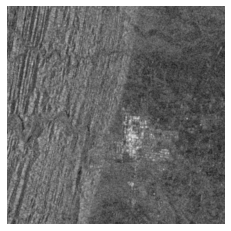

In [ ]:
show_image(vv_img, cmap='gray')

In [ ]:
vv_img.shape

(512, 512)

In [ ]:
with rasterio.open(nasadem_path) as nasadem:
    nasadem_img = nasadem.read(1)

In [ ]:
nasadem_img.shape

(512, 512)

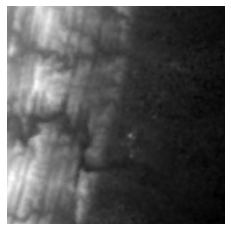

In [ ]:
show_image(nasadem_img, cmap='gray')

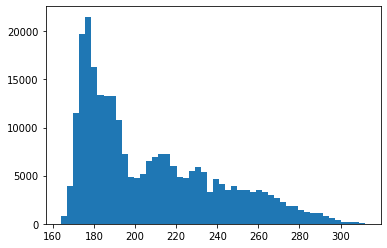

In [ ]:
plt.hist(nasadem_img.reshape(-1), bins=50)
plt.show()

In [ ]:
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]